In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"



import numpy as np
import pandas as pd
import lasagne
import theano
import theano.tensor as T
#from past import autotranslate
#autotranslate(['parmesan'])
#import parmesan
#from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
#from parmesan.layers import SimpleSampleLayer
from keras.datasets import mnist
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

theano.config.floatX = 'float32'

Using TensorFlow backend.


In [2]:
#settings
do_train_model = False
batch_size = 100
latent_size = 100
lr = 0.001
num_epochs = 50
model_filename = "svhn_conv_ae"
nplots = 5

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.tensor4()
sym_lr = T.scalar('lr')

### LOAD DATA
print ("Using SVHN dataset")

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_x = np.rollaxis(svhn_train['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

Using SVHN dataset


In [4]:
print(len(train_x))


73257


In [5]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, 3, 32, 32))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.Conv2DLayer(l_noise, num_filters = 32, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV1')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 64, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV2')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 128, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV3')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='ENC_DENSE2')

l_z = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='Z')

In [6]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='DEC_DENSE1')
l_dec_h1 = lasagne.layers.ReshapeLayer(l_dec_h1, (batch_size, -1, 4, 4))
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 128, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV1')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 64, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV2')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 32, filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV3')
l_dec_x = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_MU')
l_dec_x = lasagne.layers.ReshapeLayer(l_dec_x, (batch_size, -1))

# Get outputs from model
dec_x = lasagne.layers.get_output(l_dec_x, sym_x, deterministic=False)

In [7]:
loss = lasagne.objectives.squared_error(dec_x, sym_x.reshape((batch_size, -1)))
loss = lasagne.objectives.aggregate(loss, mode="mean")

params = lasagne.layers.get_all_params(l_dec_x, trainable=True)
for p in params:
    print (p, p.get_value().shape)

### Take gradient of Negative LogLikelihood
grads = T.grad(loss, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_CONV1.W (32, 3, 4, 4)
ENC_CONV1.b (32,)
ENC_CONV2.W (64, 32, 4, 4)
ENC_CONV2.b (64,)
ENC_CONV3.W (128, 64, 4, 4)
ENC_CONV3.b (128,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
Z.W (512, 100)
Z.b (100,)
DEC_DENSE1.W (100, 512)
DEC_DENSE1.b (512,)
DEC_CONV1.W (32, 128, 5, 5)
DEC_CONV1.b (128,)
DEC_CONV2.W (128, 64, 5, 5)
DEC_CONV2.b (64,)
DEC_CONV3.W (64, 32, 5, 5)
DEC_CONV3.b (32,)
DEC_MU.W (32, 3, 4, 4)
DEC_MU.b (3,)


In [8]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], loss, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], loss,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], dec_x,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(int(n_train_batches)):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(int(n_test_batches)):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [9]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        results = plot_results(0)
        plt.figure(figsize=(2, nplots))
        for i in range(0,nplots):
            plt.subplot(nplots,2,(i+1)*2-1)
            plt.imshow((svhn_std*test_x[i].transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
            plt.subplot(nplots,2,(i+1)*2)
            plt.imshow((svhn_std*results[i].reshape(3,32,32).transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
        plt.show()
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print (line)
    
    print ("Write model data")
    write_model(l_dec_x, model_filename)
else:
    read_model(l_dec_x, model_filename)
    

In [10]:
l_z, reconstruction = lasagne.layers.get_output([l_z, l_dec_x], inputs = sym_x, deterministic=True)
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_z =  T.vector()
adv_confusion = lasagne.objectives.squared_error(adv_z, l_z).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_z, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_l_z = theano.function([sym_x], l_z)

In [11]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    
def svhn_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 3, 32, 32)

def svhn_dist(img1, img2):
    img1_pixels = img1.flatten()*svhn_std + svhn_mean
    img2_pixels = img2.flatten()*svhn_std + svhn_mean
    return np.linalg.norm(img1_pixels - img2_pixels)

In [12]:
def adv_test(orig_img = 0, target_img = 1, C = 200.0, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Get latent variables of the target
    adv_target_z = adv_l_z(svhn_input(test_x[target_img]))
    adv_target_z = adv_target_z[0]

    original_reconstruction = adv_plot(svhn_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(svhn_input(test_x[target_img]))[0]

    orig_recon_dist = svhn_dist(original_reconstruction, test_x[orig_img])
    target_recon_dist = svhn_dist(target_reconstruction, test_x[target_img])
    orig_target_recon_dist = svhn_dist(original_reconstruction, test_x[target_img])
    target_orig_recon_dist = svhn_dist(target_reconstruction, test_x[orig_img])

    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_svhn(test_x[orig_img], 1, "Original image")
        show_svhn(original_reconstruction, 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g = adv_function(svhn_input(test_x[orig_img]), adv_target_z, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = list(zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten()))
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(svhn_input(test_x[orig_img]))[0]
    
    orig_dist = svhn_dist(adv_img, test_x[orig_img])
    adv_dist = svhn_dist(adv_img, test_x[target_img])
    recon_dist = svhn_dist(adv_img, test_x[orig_img]+x.reshape(3, 32, 32))

    # Plotting results
    if plot:
        show_svhn(x, 3, "Adversarial noise")
        show_svhn(test_x[target_img], 4, "Target image")
        show_svhn((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_svhn(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
            
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])

    returns = (np.linalg.norm(x),
               orig_dist, 
               adv_dist, 
               orig_recon_dist, 
               target_recon_dist, 
               recon_dist,
               orig_target_dist,
               orig_target_recon_dist,
               target_orig_recon_dist)
    
    return returns

In [13]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    noise_dist = []
    orig_dist=[]
    adv_dist=[]
    target_recon_dist=[]
    recon_dist=[]
    orig_target_dist=[]
    orig_target_recon_dist=[]
    target_orig_recon_dist=[]
    
    C = np.logspace(-20, 20, 100, base = 2, dtype = np.float32)
    
    for c in C:
        noise, od, ad, ore, tre, recd, otd, otrd, tord = adv_test(orig_img, target_img, C=c, plot = False)
        noise_dist.append(noise)
        orig_dist.append(od)
        adv_dist.append(ad)
        target_recon_dist.append(tre)
        recon_dist.append(recd)
        orig_target_dist.append(otd)
        orig_target_recon_dist.append(otrd)
        target_orig_recon_dist.append(tord)

    noise_dist = np.array(noise_dist)
    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    target_recon_dist = np.array(target_recon_dist)
    recon_dist = np.array(recon_dist)
    orig_target_dist = np.array(orig_target_dist)
    orig_target_recon_dist = np.array(orig_target_recon_dist)
    target_orig_recon_dist = np.array(target_orig_recon_dist)
    
    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print (orig_img, target_img, bestC)

    best_noise, best_orig_dist, best_adv_dist, orig_reconstruction_dist, target_reconstruction_dist, _, _, _, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(orig_dist, adv_dist)
        plt.scatter([best_orig_dist], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial distortion")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=np.linalg.norm(test_x[orig_img]-test_x[target_img]), linewidth = 2, color='DarkOrange', label = "Original - Target")
        plt.scatter(noise_dist, adv_dist)
        plt.scatter([best_noise], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    df = pd.DataFrame({'orig_img': orig_img,
                       'target_img': target_img,
                       'bestC': bestC,
                       'orig_reconstruction_dist': orig_reconstruction_dist,
                       'target_reconstruction_dist': target_reconstruction_dist,
                       'noise_dist': noise_dist,
                       'orig_dist': orig_dist,
                       'adv_dist': adv_dist,
                       'target_recon_dist': target_recon_dist,
                       'recon_dist': recon_dist,
                       'orig_target_dist': orig_target_dist,
                       'orig_target_recon_dist': orig_target_recon_dist,
                       'target_orig_recon_dist': target_orig_recon_dist,
                       'C': C})
    
    return df

In [ ]:
n = 25

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print ("Iter", i, "Time", time.time() - start_time, "sec")
    df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv")

In [29]:
print(len(test_x))
print(len(train_x))

26032
73257


In [66]:
# add adversarial examples to the training set and check if attacks are still effective

def gen_adv_ex(orig_img = None, target_img = None):
    
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]

    
    # Set the adversarial noise to zero
    #l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Get latent variables of the target
    adv_target_z = adv_l_z(svhn_input(test_x[target_img]))
    adv_target_z = adv_target_z[0]
    ''''
    original_reconstruction = adv_plot(mnist_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(mnist_input(test_x[target_img]))[0]

    orig_recon_dist = mnist_dist(original_reconstruction, test_x[orig_img])
    target_recon_dist = mnist_dist(target_reconstruction, test_x[target_img])
    orig_target_recon_dist = mnist_dist(original_reconstruction, test_x[target_img])
    target_orig_recon_dist = mnist_dist(target_reconstruction, test_x[orig_img])
    
    # Plot original reconstruction    
    
    if plot:
        plt.figure(figsize=(10,10))
        show_mnist(test_x[orig_img], 1, "Original image")
        show_mnist(original_reconstruction, 2, "Original reconstruction")
    '''
    C = 200.0
    # Initialize the adversarial noise for the optimization procedure
    #l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    
    
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g = adv_function(svhn_input(test_x[orig_img]), adv_target_z, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    
    bounds = list(zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten()))
    # L-BFGS-B optimization to find adversarial noise
    #x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value(), bounds = bounds, fprime = None, factr = 10, m = 25)
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(svhn_input(test_x[orig_img]))[0]
    '''    
    orig_dist = mnist_dist(adv_img, test_x[orig_img])
    adv_dist = mnist_dist(adv_img, test_x[target_img])
    recon_dist = mnist_dist(adv_img, test_x[orig_img]+x)

    # Plotting results
    if plot:
        show_mnist(x, 3, "Adversarial noise")
        show_mnist(test_x[target_img], 4, "Target image")
        show_mnist((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_mnist(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
    '''

    adv_image = test_x[orig_img] + x.reshape(3, 32, 32)
    adv_label_desired = test_y[orig_img]
    
    '''
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])

    returns = (np.linalg.norm(x),
               orig_dist, 
               adv_dist, 
               orig_recon_dist, 
               target_recon_dist, 
               recon_dist,
               orig_target_dist,
               orig_target_recon_dist,
               target_orig_recon_dist)
    
    return returns
    '''
    return (adv_image, adv_label_desired)




In [67]:
def gen_adv_ex_set(N):
    #N = 400
    adv_ex_x = []
    adv_ex_y = []
    
    for i in range(N):
        if(i%200==0):
            print("generating ",i,"th adversarial example")
        adv_x, adv_y = gen_adv_ex()
        adv_ex_x.append(adv_x)
        adv_ex_y.append(adv_y)
    #print(adv_ex_y)
    
    return (adv_ex_x, adv_ex_y)

In [68]:
def append_adv_ex():
    N = 4000
    a_x, a_y = gen_adv_ex_set(N)
    M = 15000
    print(np.shape(a_x))
    print(np.shape(train_x))
    train_x_app = np.concatenate((train_x[0:M], a_x), axis = 0)
    train_y_app = np.concatenate((train_y[0:M], a_y), axis = 0)
    print(np.shape(train_x_app))
    print(np.shape(train_y_app))
    
    '''
    N_t = 800
    M_t = 800
    test_a_x, test_a_y = gen_adv_ex_set(N_t)
    test_x_app = np.concatenate((test_x[0:M_t], test_a_x), axis = 0)
    test_y_app = np.concatenate((test_y[0:M_t], test_a_y), axis = 0)
    print(np.shape(test_x_app))
    print(np.shape(test_y_app))
    '''
    return (train_x_app, train_y_app)
    #train_x = train_x[0:M]
    #train_y = train_y[0:M]
    #train_x.append(a_x)
    #train_y.append(a_y)
    
    #print("appended " , N, " adversarial examples to ", M, "original training examples")
#append_adv_ex()

In [69]:
train_x_app, train_y_app = append_adv_ex()

generating  0 th adversarial example
(40, 3, 32, 32)
(73257, 3, 32, 32)
(1540, 3, 32, 32)
(1540,)


In [70]:
train_x_app = train_x_app.astype(np.float32)

In [71]:
do_train_model = False
batch_size = 100
latent_size = 100
lr = 0.001
num_epochs = 50
model_filename = "svhn_adv_trained_ae"
nplots = 5

np.random.seed(1234) # reproducibility

In [79]:
svhn_app_mean = np.mean(train_x_app)
svhn_app_std = np.std(train_x_app)

train_x_app = (train_x_app - svhn_app_mean)/svhn_app_std
#test_x = (test_x - svhn_mean)/svhn_std

n_train_batches = train_x_app.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

#setup shared variables
#sh_x_train = theano.shared(train_x_app, borrow=True)
#sh_x_test = theano.shared(test_x, borrow=True)

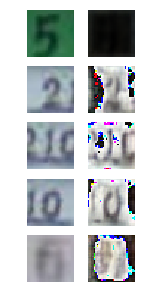

*Epoch: 0	Time: 49.92	LR: 0.00100	LL Train: 0.000	LL test: 3.952	


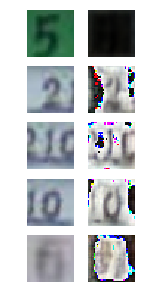

*Epoch: 1	Time: 52.12	LR: 0.00100	LL Train: 0.000	LL test: 3.813	


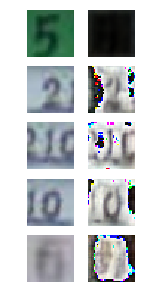

*Epoch: 2	Time: 58.07	LR: 0.00100	LL Train: 0.000	LL test: 3.660	


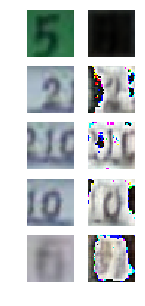

*Epoch: 3	Time: 56.68	LR: 0.00100	LL Train: 0.000	LL test: 3.499	


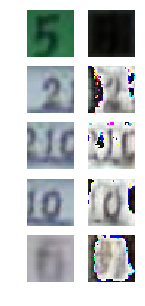

*Epoch: 4	Time: 54.41	LR: 0.00100	LL Train: 0.000	LL test: 3.361	


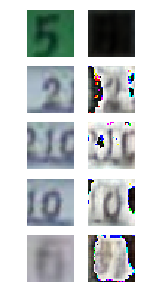

*Epoch: 5	Time: 51.47	LR: 0.00100	LL Train: 0.000	LL test: 3.229	


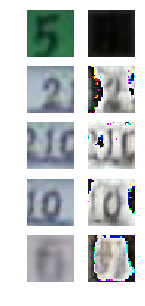

*Epoch: 6	Time: 51.68	LR: 0.00100	LL Train: 0.000	LL test: 3.059	


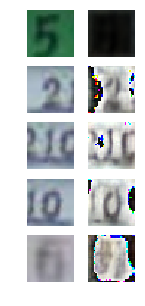

*Epoch: 7	Time: 51.79	LR: 0.00100	LL Train: 0.000	LL test: 2.934	


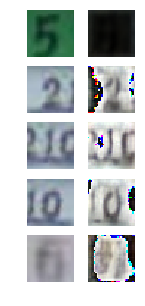

*Epoch: 8	Time: 51.19	LR: 0.00100	LL Train: 0.000	LL test: 2.781	


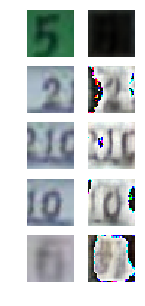

*Epoch: 9	Time: 52.30	LR: 0.00100	LL Train: 0.000	LL test: 2.679	


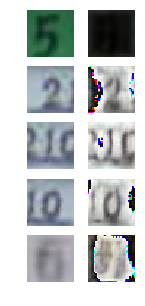

*Epoch: 10	Time: 51.90	LR: 0.00100	LL Train: 0.000	LL test: 2.548	


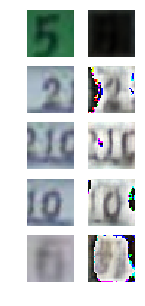

*Epoch: 11	Time: 51.69	LR: 0.00100	LL Train: 0.000	LL test: 2.448	


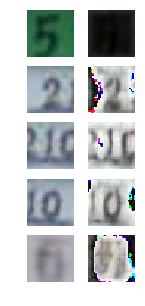

*Epoch: 12	Time: 52.25	LR: 0.00100	LL Train: 0.000	LL test: 2.344	


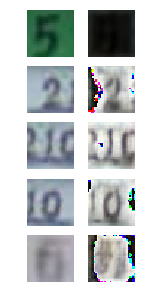

*Epoch: 13	Time: 53.53	LR: 0.00100	LL Train: 0.000	LL test: 2.222	


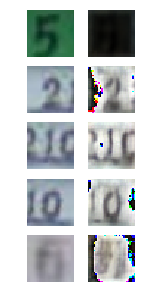

*Epoch: 14	Time: 53.09	LR: 0.00100	LL Train: 0.000	LL test: 2.130	


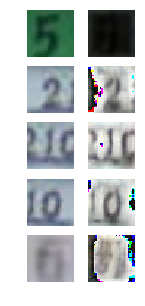

*Epoch: 15	Time: 51.87	LR: 0.00100	LL Train: 0.000	LL test: 2.072	


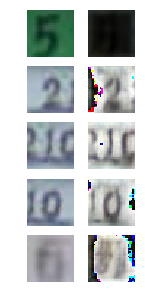

*Epoch: 16	Time: 52.91	LR: 0.00100	LL Train: 0.000	LL test: 1.998	


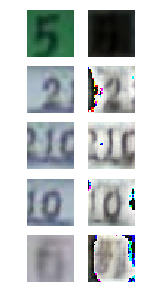

*Epoch: 17	Time: 52.88	LR: 0.00100	LL Train: 0.000	LL test: 1.878	


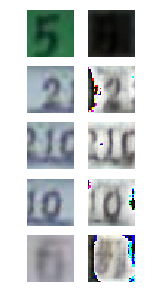

*Epoch: 18	Time: 53.58	LR: 0.00100	LL Train: 0.000	LL test: 1.853	


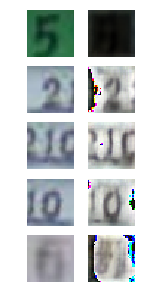

*Epoch: 19	Time: 54.09	LR: 0.00100	LL Train: 0.000	LL test: 1.840	


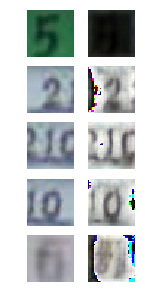

*Epoch: 20	Time: 53.92	LR: 0.00100	LL Train: 0.000	LL test: 1.784	


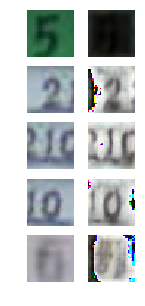

*Epoch: 21	Time: 54.14	LR: 0.00100	LL Train: 0.000	LL test: 1.710	


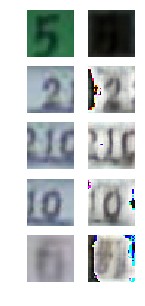

*Epoch: 22	Time: 55.24	LR: 0.00100	LL Train: 0.000	LL test: 1.676	


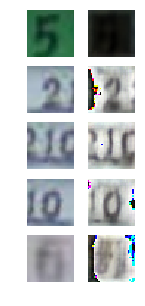

*Epoch: 23	Time: 54.57	LR: 0.00100	LL Train: 0.000	LL test: 1.632	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 24	Time: 54.22	LR: 0.00100	LL Train: 0.001	LL test: 1.630	


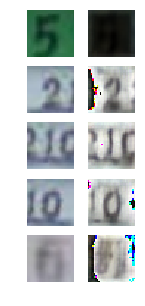

*Epoch: 25	Time: 55.33	LR: 0.00100	LL Train: 0.001	LL test: 1.631	


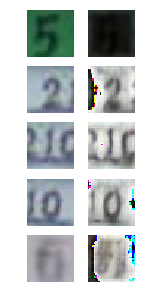

*Epoch: 26	Time: 56.56	LR: 0.00100	LL Train: 0.000	LL test: 1.575	


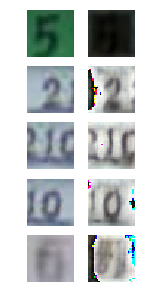

*Epoch: 27	Time: 57.44	LR: 0.00100	LL Train: 0.000	LL test: 1.560	


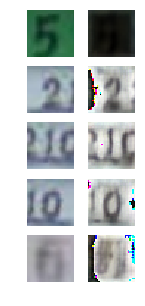

*Epoch: 28	Time: 59.94	LR: 0.00100	LL Train: 0.001	LL test: 1.557	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 29	Time: 57.02	LR: 0.00100	LL Train: 0.000	LL test: 1.471	


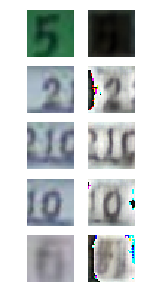

*Epoch: 30	Time: 57.60	LR: 0.00100	LL Train: 0.001	LL test: 1.462	


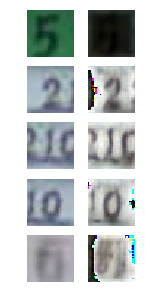

*Epoch: 31	Time: 58.40	LR: 0.00100	LL Train: 0.000	LL test: 1.437	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 32	Time: 57.07	LR: 0.00100	LL Train: 0.000	LL test: 1.408	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 33	Time: 58.03	LR: 0.00100	LL Train: 0.001	LL test: 1.393	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 34	Time: 58.85	LR: 0.00100	LL Train: 0.000	LL test: 1.330	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 35	Time: 58.59	LR: 0.00100	LL Train: 0.000	LL test: 1.266	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 36	Time: 57.73	LR: 0.00100	LL Train: 0.000	LL test: 1.184	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 37	Time: 58.10	LR: 0.00100	LL Train: 0.001	LL test: 1.231	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 38	Time: 57.76	LR: 0.00100	LL Train: 0.001	LL test: 1.222	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 39	Time: 58.24	LR: 0.00100	LL Train: 0.000	LL test: 1.191	


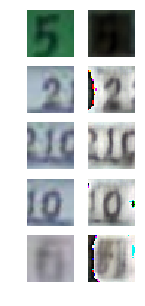

*Epoch: 40	Time: 58.37	LR: 0.00100	LL Train: 0.001	LL test: 1.230	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 41	Time: 58.71	LR: 0.00100	LL Train: 0.000	LL test: 1.173	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 42	Time: 59.29	LR: 0.00100	LL Train: 0.000	LL test: 1.150	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 43	Time: 58.64	LR: 0.00100	LL Train: 0.000	LL test: 1.185	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 44	Time: 59.34	LR: 0.00100	LL Train: 0.000	LL test: 1.146	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 45	Time: 58.94	LR: 0.00100	LL Train: 0.000	LL test: 1.125	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 46	Time: 58.62	LR: 0.00100	LL Train: 0.001	LL test: 1.121	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 47	Time: 59.35	LR: 0.00100	LL Train: 0.001	LL test: 1.156	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 48	Time: 58.46	LR: 0.00100	LL Train: 0.001	LL test: 1.174	


ValueError: Floating point image RGB values must be in the 0..1 range.

*Epoch: 49	Time: 58.89	LR: 0.00100	LL Train: 0.000	LL test: 1.144	
Write model data


In [85]:
for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x_app)
        sh_x_train.set_value(train_x_app, borrow = True)
        
        results = plot_results(0)
        plt.figure(figsize=(2, nplots))
        for i in range(0,nplots):
            plt.subplot(nplots,2,(i+1)*2-1)
            plt.imshow((svhn_app_std*test_x[i].transpose(1,2,0)+svhn_app_mean)/255.0)
            plt.axis('off')
            plt.subplot(nplots,2,(i+1)*2)
            plt.imshow((svhn_app_std*results[i].reshape(3,32,32).transpose(1,2,0)+svhn_app_mean)/255.0)
            plt.axis('off')
        plt.show()
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print (line)
    
print ("Write model data")
write_model(l_dec_x, model_filename)

In [86]:
read_model(l_dec_x, model_filename)

17830 4829 76.778275


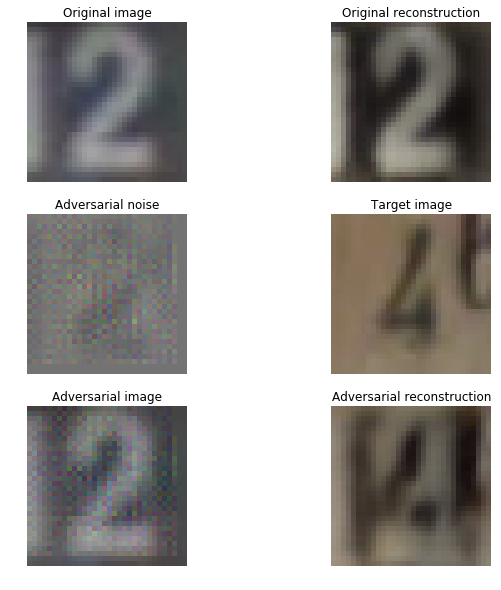

Iter 0 Time 1427.079894065857 sec


KeyboardInterrupt: 

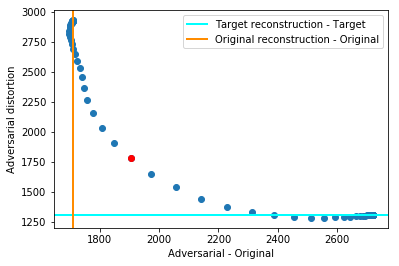

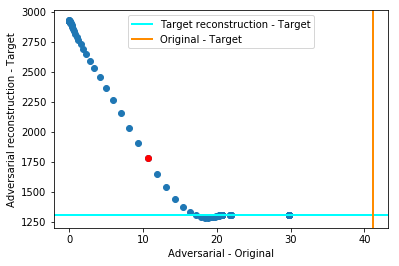

In [90]:
n = 10

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print ("Iter", i, "Time", time.time() - start_time, "sec")
    #print(df.values)
    #f = "results/" + model_filename + "/exp_" + str(i) + ".txt"
    #np.savetxt(f, df.values, fmt = "%d")
    #df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv", decimal=',', sep=' ', float_format='%.3f')

In [ ]:
svhn_app_mean = np.mean(train_x_app)
svhn_app_std = np.std(train_x_app)
print(svhn_app_mean)
print(svhm_app_std)